In [2]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [3]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/figure6'

In [4]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [5]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

In [7]:
def skeletonize(nn, groups, labels, min_pct=1):
    
    row = []
    col = []
    weight = []
    
    for i, c1 in enumerate(groups):
        n_c1 = (labels == c1).sum()
        rc1 = labels[nn.row] == c1
        cc1 = labels[nn.col] == c1
        c1_internal = (rc1 & cc1).sum()
        for j, c2 in enumerate(groups):
            n_c2 = (labels == c2).sum()
            rc2 = labels[nn.row] == c2
            cc2 = labels[nn.col] == c2
            c2_internal = (rc2 & cc2).sum()
            c1c2_between = ((rc1 & cc2) | (rc2 & cc1)).sum()
            f = n_c1 / (n_c1 + n_c2)
            expected_fraction = (2 * f - 2 * f**2)
            observed_fraction = c1c2_between / (c1_internal + c2_internal + c1c2_between)
            # if observed_fraction > expected_fraction * (self.min_pct / 100):
            if observed_fraction > (min_pct / 100):
                row.append(i)
                col.append(j)
                weight.append(observed_fraction / expected_fraction)
                
    # make matrix of edges            
    n_clusters = len(groups)
    overlap = sparse.coo_matrix((weight, (row, col)), shape=(n_clusters, n_clusters)).A
    
    # remove edges within a group
    np.fill_diagonal(overlap, 0)
    
    return overlap

In [8]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# What genes vary across astrocytes?

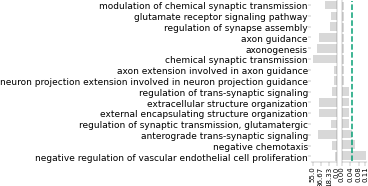

In [26]:
with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:
    top_genes = ds.ra.Gene[ds.ra.Selected == 1]
    df = gget.enrichr(top_genes, database="ontology")
    go_plot(df, n_top=15, filename=f'{figure_folder}/top_variable_GO.pdf')

# Clusters

In [25]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Clusters))

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.agg.loom', 'r') as ds:
    ordering = hc.leaves_list(ds.attrs.euclidean_linkage)
    cluster_dict = dict(zip(ordering, ds.ca.Clusters))   

155025
13


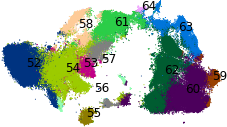

In [26]:
plt.figure(None, (4, 4))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:
    labels = np.array([cell_dict.get(x) for x in ds.ca.CellID])

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:

    print(ds.shape[1])
    print(ds.ca.Clusters.max() + 1)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    for c in np.unique(labels):
        mean = ds.ca.TSNE[labels == c].mean(axis=0)
        ax.text(mean[0], mean[1], cluster_dict[c], fontsize=12)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')

In [28]:
with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:
    print(
        dict(zip(ds.ca.Clusters, [cluster_dict.get(x) for x in labels]))
    )

{0: 52, 1: 53, 2: 54, 3: 55, 4: 61, 5: 58, 6: 57, 7: 56, 8: 64, 9: 63, 10: 62, 11: 60, 12: 59}


155025
13


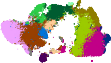

In [14]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:

    print(ds.shape[1])

    labels = ds.ca.Clusters
    print(ds.ca.Clusters.max() + 1)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/astrocyte_clusters.pdf', dpi=300)

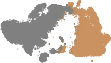

In [11]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_C_Clean.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2).flatten()

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters]
    colors = np.array(['grey' if x==0 else cbl[5] for x in labels])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)

    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/astrocyte_type.pdf', dpi=300)

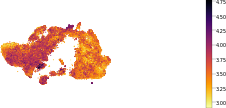

In [14]:
plt.figure(None, (4, 2))

with loompy.connect(f'{folder}/harmony_B_C_Clean.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    ax.set_aspect('equal')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
        
    plt.savefig(f'{figure_folder}/astrocyte_umi.pdf', dpi=300)

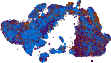

In [13]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:

    labels = ds.ca.Donor
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/astrocyte_donor.pdf', dpi=300)

# Fibrous

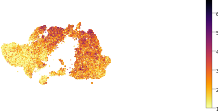

In [15]:
g = 'GFAP'

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:

    plt.figure(None, (4, 2))
    
    ax = plt.subplot(121)
    
    exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1) 
    # exp = exp / np.percentile(exp, 98)
    cells = exp > 0
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')

    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(f'{figure_folder}/astrocyte_GFAP.pdf', dpi=300)

# Cortical astrocytes 

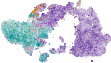

In [18]:
# note make percentile

with loompy.connect(f'{folder}/harmony_B_C_Clean.loom', 'r') as ds:
    genes = ["WIF1", "LMO2", "TNC"]
    plt.figure(None, (2, 2))
    ax = plt.subplot(111)
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=["darkcyan", "darkorange", "rebeccapurple"],
        bgval=0,
        labels=genes,
        rasterized=True,
        s=1,
        legend=None
    )
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'/home/kimberly/figures/figure6/astrocyte_cortical_markers.pdf', dpi=300)

# Region distributions

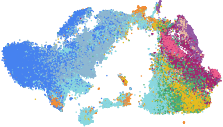

In [19]:
plt.figure(None, (4, 4))
ax = plt.subplot(111)

with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:
    
    roi_group_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    colors = np.array([color_dict[x] for x in roi_group_attr])

    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colors[cells], s=2, lw=0, rasterized=True)
    
    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig('/home/kimberly/figures/figure6/astrocyte_regions.pdf', dpi=300)

In [20]:
roi_grp_order = [
        'Cerebral cortex',
        'Hippocampus',
        'Claustrum',
        'Basal nuclei',
        'Basal forebrain',
        'Amygdaloid complex',
        'Extended amygdala',
        'Hypothalamus',
        'Thalamus', 
        'Midbrain',
        'Cerebellum',
        'Pons',
        'Myelencephalon',
        'Spinal cord'
    ]

In [ ]:
df = pd.read_csv('roi_group_table.csv')
df.head()

,Unnamed: 0,index,ROI Group,Order,ROI Group Coarse
0,78,Human A13,Cerebral cortex,0,Cerebral cortex
1,81,Human A14,Cerebral cortex,0,Cerebral cortex
2,45,Human A19,Cerebral cortex,0,Cerebral cortex
3,68,Human A1C,Cerebral cortex,0,Cerebral cortex
4,61,Human A23,Cerebral cortex,0,Cerebral cortex


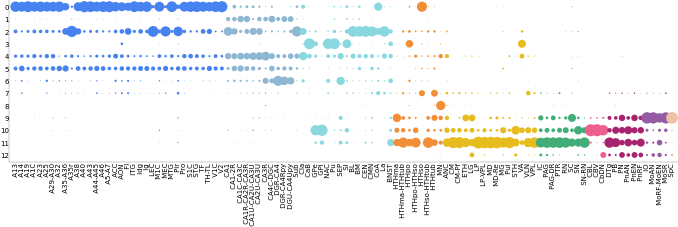

In [23]:
plt.figure(None, (12, 3))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_C_Clean.loom', 'r') as ds:
        
    # get ROIs and order by ROI Groups
    rois = df['index'].to_numpy()
    roi_attr = clean_roi(ds.ca.Roi)
    total_counts = np.array([(roi_attr == r).sum() for r in rois])
    rois = rois[total_counts > 50]
    total_counts = total_counts[total_counts > 50]
    clusters, labels = np.unique(
        ds.ca.Clusters,
        return_inverse=True
    )
    
    roi_counts = []
    x = []
    y = []
    colors = []
    for i, r in enumerate(rois):
        agg = npg.aggregate(labels, roi_attr == r) / total_counts[i]
        roi_counts.append(agg)
        x.append( [i] * len(clusters) )
        y.append( range(len(clusters)) )
        c = color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]]
        colors = colors + [c] * len(clusters)

    roi_counts = np.hstack(roi_counts)
    x = np.hstack(x)
    y = np.hstack(y)

    plt.scatter(x, y, s=roi_counts * 150, c=colors, rasterized=True, lw=0)
    ax.tick_params(length=0)
    ax.invert_yaxis()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.xticks(range(len(rois)), pd.Series(rois).str.replace('Human', ''), rotation=90, fontsize=7)
    plt.yticks(range(len(clusters)), clusters, fontsize=7)
    plt.margins(0.01, 0.05)
    
    plt.savefig('/home/kimberly/figures/figure6/astrocyte_region_dot.pdf', dpi=300)

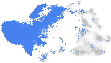

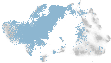

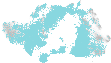

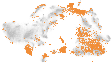

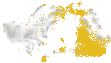

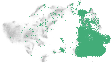

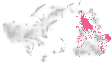

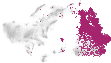

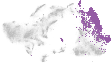

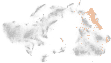

In [158]:
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    roi_group_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))

with loompy.connect(f'{folder}/harmony_B_C_Clean.loom', 'r') as ds:
    
    roi_group_coarse = np.array([roi_group_dict.get(x) for x in ds.ca.CellID])
    
    for i, grp in enumerate(df['ROI Group Coarse'].unique()):

        plt.figure(None, (2, 2))
        ax = plt.subplot(111)
        
        cells = roi_group_coarse == grp
        
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.01, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], color=color_dict[grp], s=1, lw=0, rasterized=True)

        ax.set_aspect('equal')
        plt.margins(0.01, 0.01)
        plt.axis('off')
        plt.savefig(f'{figure_folder}/astrocyte_region_{i}_{grp}.pdf', dpi=300)

In [170]:
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    roi_attr = clean_roi(ds.ca.Roi)
    subset = ds.ca.ROIGroupCoarse
    subset[np.isin(ds.ca.ROIGroupFine, ['Amygdaloid complex', 'Extended amygdala'])] = "Amygdala"
    subset[np.isin(ds.ca.ROIGroupFine, ["Basal nuclei"])] = "Basal nuclei"
    subset[np.isin(roi_attr, ['Human MEC', 'Human LEC', 'Human Pir', 'Human A35r'])] = "Rhinal cortex"
    subset[np.isin(roi_attr, ['Human SI'])] = "SI"
    subset[np.isin(roi_attr, ['Human BNST'])] = "BNST"
    subset[np.isin(roi_attr, ['Human SEP'])] = "SEP"
    subset[np.isin(roi_attr, ['Human Cla'])] = "Claustrum"
    subset[np.isin(roi_attr, ['Human GPe', 'Human GPi'])] = "Globus pallidus"
    print(np.unique(subset))
    
    grouping_dict = dict(zip(ds.ca.CellID, subset))

with loompy.connect(f'{folder}/harmony_B_C_Clean.loom', 'r') as ds:
    
    labels = np.array([grouping_dict.get(x) for x in ds.ca.CellID])
    groups, node_size = np.unique(labels, return_counts=True)
    
    # skeletonize
    overlap = skeletonize(ds.col_graphs.KNN, groups, labels, min_pct=1)

['Amygdala' 'BNST' 'Basal nuclei' 'Cerebellum' 'Cerebral cortex'
 'Claustrum' 'Globus pallidus' 'Hippocampus' 'Hypothalamus' 'Midbrain'
 'Myelencephalon' 'Pons' 'Rhinal cortex' 'SEP' 'SI' 'Spinal cord'
 'Thalamus']


In [174]:
# make graph
G = nx.from_numpy_array(overlap)

# rename nodes
nx.relabel_nodes(
    G, 
    dict(zip(range(len(groups)), groups)),
    copy=False)

# get edge weights and scale
edge_weight = np.divide(
    list(nx.get_edge_attributes(G, 'weight').values()), 
    2
)

# color nodes based on ROI group
with loompy.connect(f"{folder}/Pool.loom", "r") as ds:
    roi_group_dict = dict(zip(subset, ds.ca.ROIGroupCoarse))
roi_group_coarse = np.array([roi_group_dict.get(x) for x in groups])
node_color = [color_dict[r] for r in roi_group_coarse]

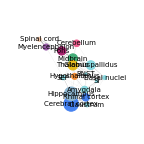

In [181]:
plt.figure(None, (2, 2))
nx.draw(G, node_size=node_size / 150, with_labels=True, font_size=7, width=edge_weight, node_color=node_color)
plt.margins(0.5, 0.5)
plt.tight_layout()
plt.savefig(f'{figure_folder}/astrocyte_region_graph.pdf', dpi=300)

# Specific clusters

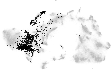

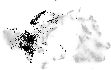

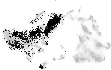

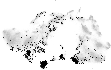

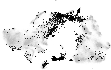

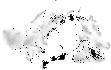

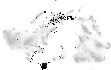

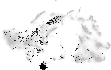

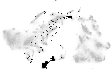

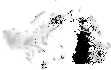

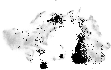

In [56]:
for r in ['LEC', 'MEC', 'Cla', 'SI', 'SEP', 'BNST', 'CaB', 'Pu', 'NAC', 'GPi', 'GPe']:
    
    with loompy.connect(f'{folder}/harmony_B_C_Clean.loom', 'r') as ds:
    
        plt.figure(None, (2, 2))
        ax = plt.subplot(111)
        
        cells = ds.ca.Roi == 'Human ' + r
        
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.01, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], color='black', s=1, lw=0, rasterized=True)

        ax.set_aspect('equal')
        plt.margins(0.01, 0.01)
        plt.axis('off')
        plt.title(r, fontsize=0.5)
        
        plt.savefig(f'{figure_folder}/astrocyte_roi_{r}.pdf', dpi=300)

['Human BL' 'Human BM' 'Human CEN' 'Human CMN' 'Human CoA' 'Human La']


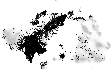

In [59]:
with loompy.connect(f'{folder}/harmony_B_C_Clean.loom', 'r') as ds:

    plt.figure(None, (2, 2))
    ax = plt.subplot(111)

    cells = pd.Series(ds.ca.Tissue).str.contains('Amygdaloid').to_numpy()
    print(np.unique(ds.ca.Roi[cells]))

    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.01, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], color='black', s=1, lw=0, rasterized=True)

    ax.set_aspect('equal')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.title(r, fontsize=0.5)

    plt.savefig(f'{figure_folder}/astrocyte_roi_amygdala.pdf', dpi=300)

# Enriched genes

In [9]:
with loompy.connect(f'{folder}/harmony_B_C_Clean.agg.loom', 'r') as ds:    
        
    n_labels = ds.ca.Clusters.max() + 1
    n_markers = 5
    excluded = set(
        np.where(
            (ds.ra.Valid == 0) | pd.Series(ds.ra.Gene).isin(ncRNA_genes).to_numpy()
        )[0]
    )

    included = []
    for ix in range(n_labels):
        print(ix)
        enriched = np.argsort(ds.layers["enrichment"][:, ix])[::-1]
        n = 0
        count = 0
        while count < n_markers:
            if enriched[n] in excluded:
                n += 1
                continue
            included.append(enriched[n])
            excluded.add(enriched[n])
            n += 1
            count += 1
            
    markers = np.array(included)

0
1
2
3
4
5
6
7
8
9
10
11
12


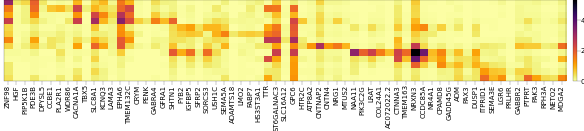

In [10]:
with loompy.connect(f'{folder}/harmony_B_C_Clean.agg.loom', 'r') as ds:
    
    plt.figure(None, (12, 1.5))
    data = np.vstack([ds[ix, :] for ix in markers])
    data = np.log2(data + 1)
    plt.imshow(data.T, aspect='auto', interpolation='nearest', cmap='inferno_r')
    plt.xticks(range(len(markers)), ds.ra.Gene[markers], rotation='vertical', fontsize=7)
    plt.margins(0, 0)
    plt.yticks([])
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.tick_params(labelsize=7)
    plt.savefig(f'{figure_folder}/astrocyte_markers.pdf', dpi=300)

In [11]:
colors = colorize(np.arange(data.shape[1]))
# data = np.array([tuple(int(c.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for c in colors])
plt.figure(None, (1.5, 0.25))
plt.imshow(np.expand_dims(colors, axis=0), aspect='auto', interpolation='nearest')
plt.axis('off')
plt.savefig(f'{figure_folder}/astrocyte_cluster_bar.pdf', dpi=300)